# ImageDataGenerator

In [1]:
import os
from glob import glob

import tensorflow as tf
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### ImageDataGenerator 

 - 데이터를 불러오는 동시에 여러가지 전처리를 쉽게 구현 할 수 있는 tf.keras의 기능! 

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

### flow

- 데이터를 모두 메모리에 불러두고 사용 할 때

In [5]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

cifar10_loader = Cifar10DataLoader()
train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32


0.0002920478 1.0 0.45627668
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


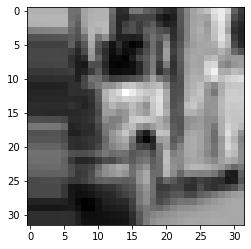

In [22]:
# 이코드를 여러번 실행해보면서 바뀌는 걸 한번 보세요! 데이터가 바뀌어서 출력되지요? 
result = next(iter(datagen.flow((train_x, train_y))))

x, y = result
# print(np.min(result), np.max(result), np.mean(result))
print(np.min(x), np.max(x), np.mean(x))
print(y[0])

plt.imshow(x[0, :, :, 0], 'gray')
plt.show()

0.007916831 0.9840196 0.40479925
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


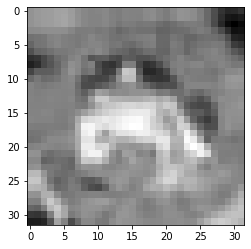

In [23]:
# 이코드를 여러번 실행해보면서 바뀌는 걸 한번 보세요! 같은 그림인데 자꾸 바뀌죠?? 
x = next(iter(datagen.flow(train_x[:1])))
         
# print(np.min(result), np.max(result), np.mean(result))
print(np.min(x), np.max(x), np.mean(x))
print(y[0])

plt.imshow(x[0, :, :, 0], 'gray')
plt.show()

### flow_from_directory 

In [25]:
train_dir = "../../datasets/mnist_png/training"

In [28]:
input_shape = (28, 28, 1)
batch_size = 32

In [31]:
datagen.flow_from_directory(
    train_dir, 
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='grayscale',#rgb, rgba 
)

Found 60000 images belonging to 10 classes.


In [32]:
x, y = next(iter(datagen.flow((train_x, train_y))))

In [33]:
print(x.shape)
print(y.shape)

(32, 32, 32, 3)
(32, 10)


### flow_from_DataFrame

In [35]:
import pandas as pd

In [70]:
train_data = pd.read_csv("../../datasets/cifar/train_dataset.csv")

In [69]:
datagen.flow_from_dataframe(
    train_data,
    x_col="path",
    y_col="class_name",
    target_size=(32, 32),
    color_mode="rgb",
    class_model="categorical",
    batch_size=32
)

Found 10000 validated image filenames belonging to 10 classes.


In [71]:
x, y = next(iter(datagen.flow((train_x, train_y))))

In [72]:
print(x.shape)
print(y.shape)

(32, 32, 32, 3)
(32, 10)


학습시켜보겠습니다. 

In [73]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides=2,
                 padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net1_1 = Conv2D(64, kernel_size=1, padding='same')(net)
    net = Add()([net1_1, net3])
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3])
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation="softmax")(net)

    model = tf.keras.Model(inputs=inputs, outputs=net, name='resnet')
    
    return model

model = build_resnet((32, 32, 3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 32)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     2112        ['max_pooling2d[0][0]']          
                                                                                             

2022-01-26 21:21:17.310710: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [76]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [77]:
model.fit(datagen.flow((train_x, train_y)))

  99/1563 [>.............................] - ETA: 43s - loss: 2.8153 - accuracy: 0.1051

KeyboardInterrupt: 